# Multi Agent Systems

## General Imports

In [1]:
from scipy.interpolate import interp1d

import hashlib
import matplotlib.pyplot as plt
import numpy as np

## Agents

In [2]:
class Bot:
    def __init__(self, rounds, players, bal_per_round, init_balance, first_price):
        self.first_price = first_price
        self.init_balance = init_balance
        self.balance = init_balance
        self.rounds = rounds
        self.opponents = players - 1
        self.bal_per_round = bal_per_round
        self.curr_round = -1
        self.avg_balance = init_balance / rounds
        self.bidding_power = 0

    def pre_round(self, winner, win_amount):
        self.curr_round += 1
        self.balance += self.bal_per_round
        self.bidding_power += self.avg_balance
        
        if winner == 0:
            self.balance -= win_amount
            self.bidding_power -= win_amount
        if self.bidding_power < 0:
            self.bidding_power = 0

    def play_round(self, winner, win_amount):
        pass

In [3]:
class BigBidderBot(Bot):
    def play_round(self, winner, win_amount):
        super().pre_round(winner, win_amount)
        # if the agent is given a specific amount of money each round
        if self.init_balance == 0:
            # he bids all his current money
            return self.balance
        # if the agent is given an initial balance
        else:
            # he bids all his bidding power
            return self.bidding_power            

In [4]:
class RandomBot(Bot):
    def play_round(self, winner, win_amount):
        super().pre_round(winner, win_amount)
        # if the agent is given a specific amount of money each round
        if self.init_balance == 0:
            # he bids a random amount of money depending on his current balance
            return np.random.randint(0, self.balance)
        # if the agent is given an initial balance
        else:
            # he bids a random amount of money depending on his current bidding power
            return np.random.randint(0, self.bidding_power)

In [5]:
class CopycatBot(Bot):
    def play_round(self, winner, win_amount):
        super().pre_round(winner, win_amount)
        # if the agent is given a specific amount of money each round
        if self.init_balance == 0:
            # if he has as much money as the previous winner's bid, the agent bids the same amount
            if win_amount <= self.balance and win_amount != -1:
                return win_amount
            else:
                # else he bids almost all his money, actually 80% of his total balance
                return self.balance * 0.8
        # if the agent is given an initial balance
        else: 
            # if his bidding power is as much as the previous winner's bid, the agent bids the same amount
            if win_amount <= self.bidding_power and win_amount != -1:
                return win_amount
            else:
                # else he bids almost all his bidding power, actually 80% of it
                return self.bidding_power * 0.8

In [28]:
class PercentageBot(Bot):
    def play_round(self, winner, win_amount):
        super().pre_round(winner, win_amount)
        # if the agent lost on the previous round or no one won
        # he will have more money this round so he can save some and bid only 60%
        # of his total or of his bidding power
        if winner > 0:
            return self.balance * 0.6 if self.init_balance == 0 else self.bidding_power * 0.6
        # if he won
        # he will probably have less money so he must bid almost all his money to win
        else:
            return self.balance * 0.8 if self.init_balance == 0 else self.bidding_power * 0.8

In [7]:
class CounterBot(Bot):
    def __init__(self, rounds, players, bal_per_round, init_balance, first_price):
        super().__init__(rounds, players, bal_per_round, init_balance, first_price)
        self.opps = [0] * (players - 1)

    def play_round(self, winner, win_amount):
        super().pre_round(winner, win_amount)
        
        # decide the unit based on whether the auction is based
        # on a given balance per round or on an initial balance
        unit = self.bal_per_round if self.bal_per_round else self.avg_balance
        
        # update the opponents' balance (in approximation
        # for auctions with an initial balance)
        for opp in range(self.opponents):
            self.opps[opp] += unit
        
        # update the winner's balance
        if winner > 0:
            winner -= 1  # convert to index value
            if win_amount <= self.opps[winner]:
                self.opps[winner] -= win_amount
            else:
                self.opps[winner] = 0
        
        # set an upper limit for the bid
        max_bid = self.balance if self.bal_per_round else self.bidding_power
        
        # calculate the bid that counters the opponents
        for bid in sorted(self.opps, reverse=True):
            if bid < max_bid:
                return bid + 1
        
        # if we can't beat the opponents, bid our max value
        return max_bid

In [8]:
class AverageBot(Bot):
    def __init__(self, rounds, players, bal_per_round, init_balance, first_price):
        super().__init__(rounds, players, bal_per_round, init_balance, first_price)
        self.number = 0
        self.memory = 0

    def play_round(self, winner, win_amount):
        super().pre_round(winner, win_amount)
        # if the agent is given a specific amount of money each round
        if self.init_balance == 0:
            unit = self.balance
        # if the agent is given an initial balance
        else:
            unit = self.bidding_power         
        # if there is a valid bid count it
        if win_amount>0:
            self.number = self.number + 1
            self.memory = self.memory + win_amount
        bid = 0
        # if the balance is lower than 70% of the initial balance per round, then we don't have much money
        if unit <= self.bal_per_round*0.7:
            # so we bid 50% of our balance to keep some money and have at least a small chance at winning
            bid = unit*0.5
        # if the balance is higher than 70% of the initial balance per round
        elif win_amount > 0:
            # we bid the average of every winning amount until the current round
            bid = self.memory/self.number
        # if the auction type is Second Price
        if self.first_price == False:
            # the average calculated will not be accurate (it will be from the winning amount, the second biggest)
            # and we increase it by 80% so the agent will be competitive
            bid = bid + bid*0.8
        # if the average is higher than our balance
        if bid > unit:
            # we bid all of our balance
             bid = unit
        return round(bid)

In [9]:
class EvenBot(Bot):
    def play_round(self, winner, win_amount):
        super().pre_round(winner, win_amount)
        if self.init_balance==0:
            # the agent gets money at the begging of each round
            if self.curr_round % 2 != 0 or self.curr_round==(self.rounds-1):
                return self.balance
            else:
                return 1
        else:
            # if the agent starts with a balance and don't get money at every round
            if self.curr_round % 2 != 0 or self.curr_round==(self.rounds-1):
                return self.bidding_power
            else:
                return 1

In [10]:
class WinningStreakBot(Bot):
    def play_round(self, winner, win_amount):
        super().pre_round(winner, win_amount)
        # The agent get money at the beggining of each round
        if self.init_balance==0:
            # If the agent won the last round, keep on trying to win
            if winner == 0 or winner == -1:
                return self.balance
            else:
                # If you can pay the last win amount + 1
                if self.balance > win_amount + 1:
                    return win_amount + 1
                # If not, dont try to bid, accumulate budget
                else:
                    return 0

        # The agent starts with a balance
        else:
            # If the agent won the last round, keep on trying to win
            # but maintain a balance by using bidding_power
            if winner == 0 or winner == -1:
                return self.bidding_power
            else:
                # If you can pay the last win amount + 1
                if self.bidding_power > win_amount + 1:
                    return win_amount + 1
                # If not, dont try to bid, accumulate budget
                else:
                    return 0

In [11]:
class AvoidLosingBot(Bot):
    def play_round(self, winner, win_amount):
        super().pre_round(winner, win_amount)
        # The agent get money at the beggining of each round
        if self.init_balance==0:
            # If the agent lost the last round,
            # attempt to take back the winning status
            if winner != 0 or winner == -1:
                return self.balance
            else:
                # If you can pay the last win amount + 1
                if self.balance > win_amount + 1:
                    return win_amount + 1
                # If not, dont try to bid, accumulate budget
                else:
                    return 0

        # The agent starts with a balance
        else:
            # If the agent lost the last round, attemt to take back
            # the winning status but maintain a balance by using bidding_power
            if winner != 0 or winner == -1:
                return self.bidding_power
            else:
                # If you can pay the last win amount + 1
                if self.bidding_power > win_amount + 1:
                    return win_amount + 1
                # If not, dont try to bid, accumulate budget
                else:
                    return 0

## Variables

In [29]:
bot_list = [
    # add bots from previous blocks
    PercentageBot,
    CounterBot,
    AverageBot,
    CopycatBot,
    EvenBot,
    WinningStreakBot,
    AvoidLosingBot,
    BigBidderBot,
    RandomBot,
]

N = len(bot_list)

## Util Classes

In [13]:
class Bid:
    def __init__(self, index, amount):
        self.index = index
        self.amount = amount

## Auction

In [14]:
def shuffle_order(num_list):
    n = len(num_list)
    hash_index = int(hashlib.sha1(str(num_list).encode()).hexdigest(), 16) % 24
    result = []
    for i in range(n, 0, -1):
        result.append(num_list[hash_index % i])
        del num_list[hash_index % i]
        hash_index //= i
    return result

In [15]:
def auction(agent_indexes, rounds, bal_per_round, init_balance, first_price):
    agent_indexes = shuffle_order(agent_indexes)
    agents = [bot_list[i](rounds, len(agent_indexes), bal_per_round, init_balance, first_price) for i in agent_indexes]

    score = [0] * N
    total = [0] * N
    balance = [init_balance] * N

    (prev_winner, prev_bid) = (-1, -1)
    for _round in range(rounds):
        bids = []
        for i in range(N):
            balance[i] += bal_per_round

            if prev_winner == i:
                prev_winner = 0
            elif prev_winner != -1 and prev_winner < i:
                prev_winner += 1

            bid = int(agents[i].play_round(prev_winner, prev_bid))
            if bid < 0 or bid > balance[i]:
                name = bot_list[agent_indexes[i]].__name__
                raise ValueError("Agent #%s tried to bid with an invalid amount (%d)" % (name, bid))
            bids.append(Bid(i, bid))

        bids.sort(reverse=True, key= lambda b: b.amount)

        winner = -1
        top_bid = bids[0].amount
        for i in range(1, N):
            if bids[i].amount == top_bid:
                winner = -1
                bids[i].amount = -1
                bids[i - 1].amount = -1
            else:
                if bids[i - 1].amount == -1:
                    winner = i
                    top_bid = bids[i].amount
                else:
                    winner = i - 1
                    break

        if winner == -1:
            (prev_winner, prev_bid) = (-1, -1)
        else: 
            w_bid = bids[winner]
            
            if first_price or len(bids) == winner + 1:
                prev_bid = w_bid.amount
            else:
                prev_bid = bids[winner + 1].amount
                
            prev_winner = w_bid.index
            score[agent_indexes[prev_winner]] += 1
            total[agent_indexes[prev_winner]] += prev_bid
            balance[prev_winner] -= prev_bid

    return score, total

In [16]:
def show_results(score, total):
    results = sorted(map(list, zip(score, total, bot_list)), key= lambda k: (-k[0], k[1]))

    for score, total, agent in results:
        name = agent.__name__
        avg = total / score
        print("%-20s Wins: %-6d Total Spent: %-9d Avg Spent per Win: %.2f" % (name, score, total, avg))

In [17]:
def simulate(experiments=10, rounds=10, bal_per_round=0, init_balance=0, first_price=True, print_experiments=False):
    scores = []
    totals = []
    
    for _ in range(experiments):
        agent_indexes = list(range(N))
        (score, total) = auction(agent_indexes, rounds, bal_per_round, init_balance, first_price)
        scores.append(np.array(score))
        totals.append(np.array(total))
        
        if print_experiments:
            print("End of experiment")
            show_results(score, total)
            print()
    
    print("End of simulation")
    score = sum(scores)
    total = sum(totals)
    show_results(score, total)
    return scores, totals

In [18]:
def interp(y):
    n = len(y)
    x = np.linspace(0, n, n)
    x_new = np.linspace(0, n, 4 * n + 1)
    f = interp1d(x, y, kind="cubic")
    return x_new, f(x_new)

def moving_avg(timeseries, window):
    return np.convolve(timeseries, np.ones(window), "valid") / window

In [19]:
def plot_experiments(experiments, scores):
    cumulative_scores = np.cumsum(scores, axis=0)
    
    results = []
    for i in range(len(bot_list)):
        score_per_bot = []
        for j in range(experiments):
            score_per_bot.append(scores[j][i])
        results.append(score_per_bot)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,12))
    for i in range(len(results)):
        xy1 = interp(results[i])
        xy2 = interp(moving_avg(results[i], 3))
        ax1.plot(xy1[0], xy1[1], label=bot_list[i].__name__)
        ax2.plot(xy2[0], xy2[1], label=bot_list[i].__name__)
    
    ax1.set_title('Wins per experiment')
    ax2.set_title('Wins per experiment (moving average, window=3)')

    for axs in (ax1, ax2):
        axs.set_xlabel('Experiment number')
        axs.set_ylabel('Wins')
        axs.legend(loc='lower left')
        axs.grid()

## Experiments

In [20]:
(experiments, rounds) = (25, 365)
(init_balance, bal_per_round) = (50000, 500)

### First Price Auction with initial balance

End of simulation
AverageBot           Wins: 1620   Total Spent: 1241164   Avg Spent per Win: 766.15
CounterBot           Wins: 1574   Total Spent: 1239246   Avg Spent per Win: 787.32
PercentageBot        Wins: 1559   Total Spent: 1227282   Avg Spent per Win: 787.22
WinningStreakBot     Wins: 1552   Total Spent: 1239160   Avg Spent per Win: 798.43
CopycatBot           Wins: 1518   Total Spent: 1236628   Avg Spent per Win: 814.64
RandomBot            Wins: 1302   Total Spent: 1233275   Avg Spent per Win: 947.22
EvenBot              Wins: 0      Total Spent: 0         Avg Spent per Win: nan
AvoidLosingBot       Wins: 0      Total Spent: 0         Avg Spent per Win: nan
BigBidderBot         Wins: 0      Total Spent: 0         Avg Spent per Win: nan


<ipython-input-16-33f6c19cd383>:6: RuntimeWarning: invalid value encountered in long_scalars
  avg = total / score


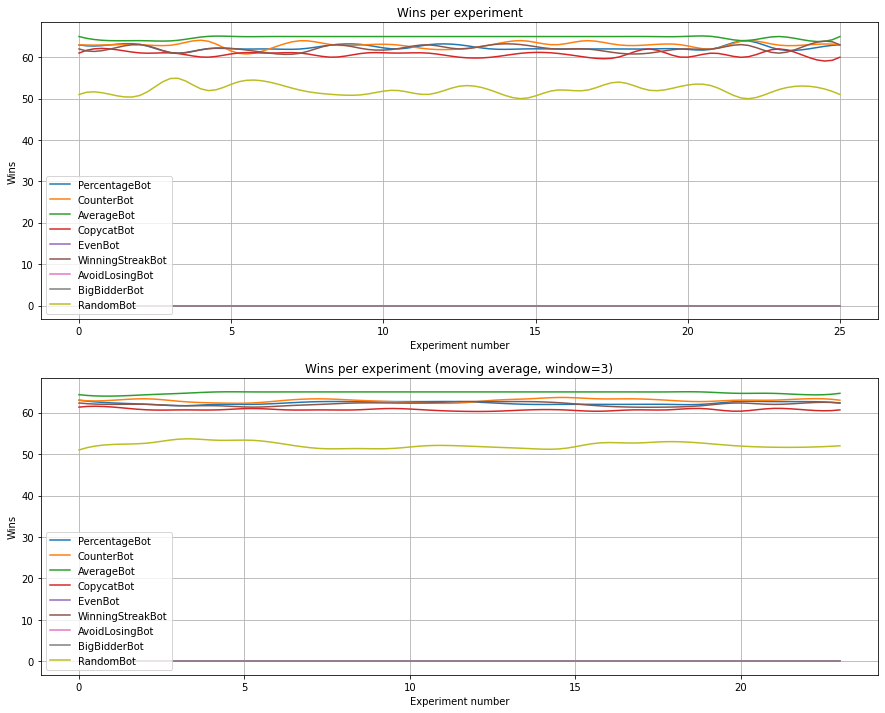

In [30]:
scores, totals = simulate(experiments, rounds, init_balance=init_balance)
plot_experiments(experiments, scores)

### Second Price Auction with initial balance

End of simulation
RandomBot            Wins: 1964   Total Spent: 1229548   Avg Spent per Win: 626.04
WinningStreakBot     Wins: 1871   Total Spent: 1237758   Avg Spent per Win: 661.55
CounterBot           Wins: 1836   Total Spent: 1237369   Avg Spent per Win: 673.95
AverageBot           Wins: 1785   Total Spent: 1238744   Avg Spent per Win: 693.97
CopycatBot           Wins: 1669   Total Spent: 895264    Avg Spent per Win: 536.41
PercentageBot        Wins: 0      Total Spent: 0         Avg Spent per Win: nan
EvenBot              Wins: 0      Total Spent: 0         Avg Spent per Win: nan
AvoidLosingBot       Wins: 0      Total Spent: 0         Avg Spent per Win: nan
BigBidderBot         Wins: 0      Total Spent: 0         Avg Spent per Win: nan


<ipython-input-16-33f6c19cd383>:6: RuntimeWarning: invalid value encountered in long_scalars
  avg = total / score


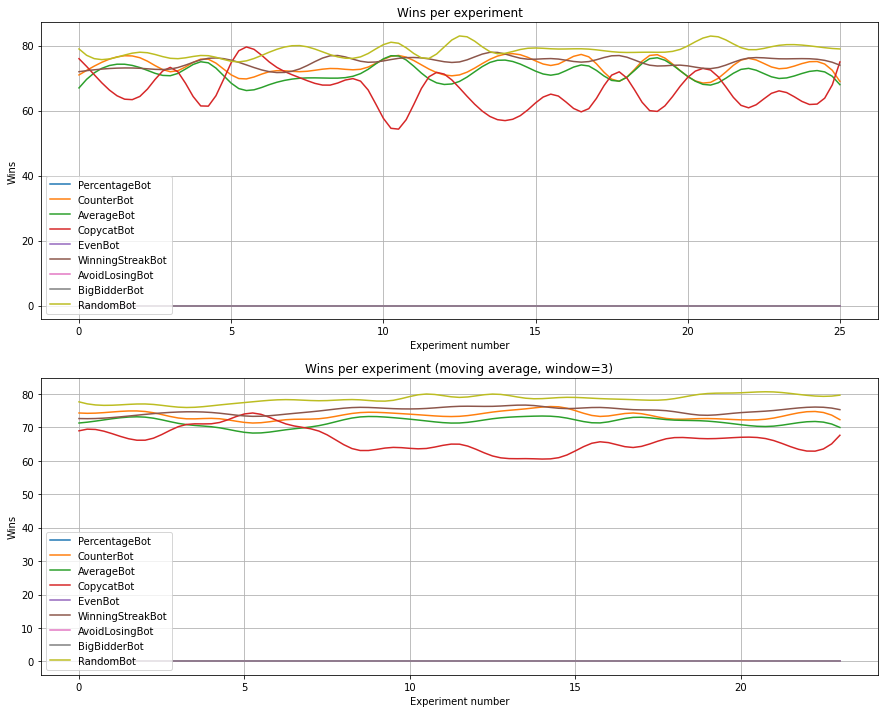

In [22]:
scores, totals = simulate(experiments, rounds, init_balance=init_balance, first_price=False)
plot_experiments(experiments, scores)

### First Price Auction with given balance per round

End of simulation
AverageBot           Wins: 1942   Total Spent: 4534612   Avg Spent per Win: 2335.02
CounterBot           Wins: 1931   Total Spent: 4516994   Avg Spent per Win: 2339.20
WinningStreakBot     Wins: 1866   Total Spent: 4529020   Avg Spent per Win: 2427.13
CopycatBot           Wins: 1841   Total Spent: 4525182   Avg Spent per Win: 2458.00
RandomBot            Wins: 1545   Total Spent: 4513506   Avg Spent per Win: 2921.36
PercentageBot        Wins: 0      Total Spent: 0         Avg Spent per Win: nan
EvenBot              Wins: 0      Total Spent: 0         Avg Spent per Win: nan
AvoidLosingBot       Wins: 0      Total Spent: 0         Avg Spent per Win: nan
BigBidderBot         Wins: 0      Total Spent: 0         Avg Spent per Win: nan


<ipython-input-16-33f6c19cd383>:6: RuntimeWarning: invalid value encountered in long_scalars
  avg = total / score


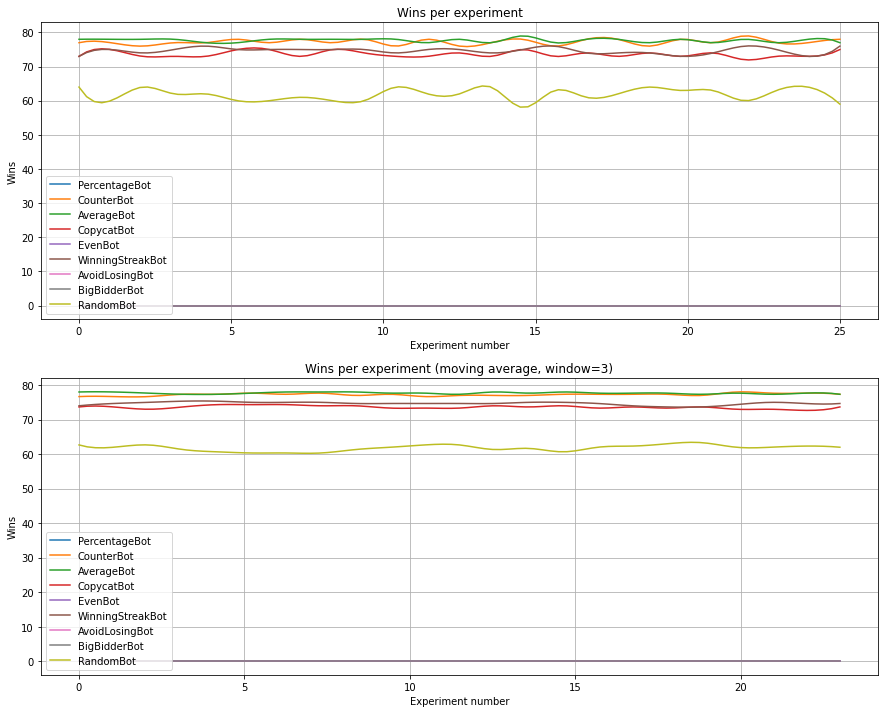

In [23]:
scores, totals = simulate(experiments, rounds, bal_per_round=bal_per_round)
plot_experiments(experiments, scores)

### Second Price Auction with given balance per round

End of simulation
CounterBot           Wins: 1953   Total Spent: 4517544   Avg Spent per Win: 2313.13
RandomBot            Wins: 1945   Total Spent: 4503386   Avg Spent per Win: 2315.37
AverageBot           Wins: 1894   Total Spent: 4523880   Avg Spent per Win: 2388.53
WinningStreakBot     Wins: 1861   Total Spent: 4501921   Avg Spent per Win: 2419.09
CopycatBot           Wins: 1472   Total Spent: 2955464   Avg Spent per Win: 2007.79
PercentageBot        Wins: 0      Total Spent: 0         Avg Spent per Win: nan
EvenBot              Wins: 0      Total Spent: 0         Avg Spent per Win: nan
AvoidLosingBot       Wins: 0      Total Spent: 0         Avg Spent per Win: nan
BigBidderBot         Wins: 0      Total Spent: 0         Avg Spent per Win: nan


<ipython-input-16-33f6c19cd383>:6: RuntimeWarning: invalid value encountered in long_scalars
  avg = total / score


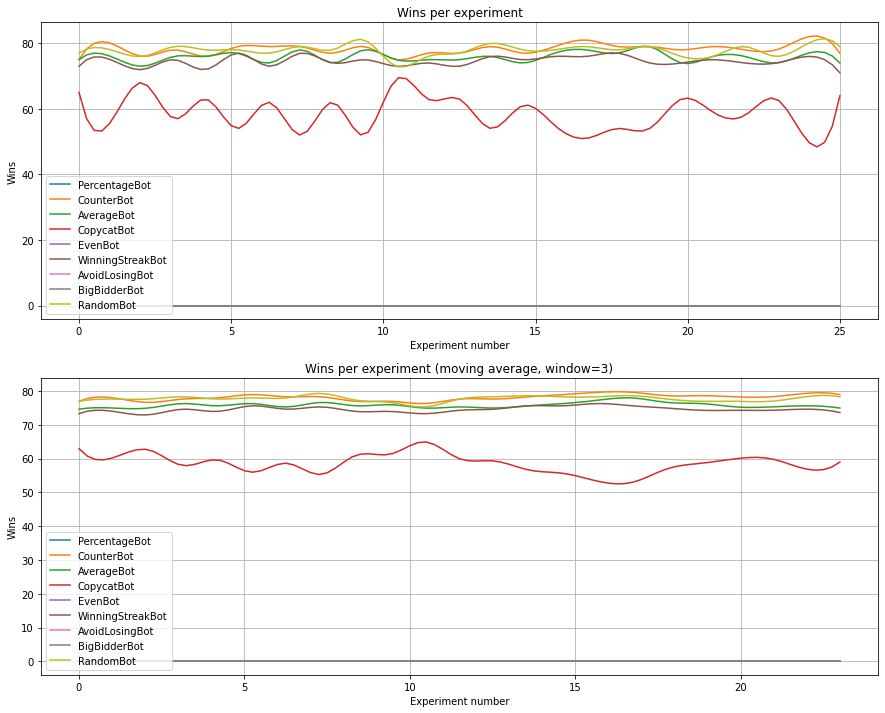

In [24]:
scores, totals = simulate(experiments, rounds, bal_per_round=bal_per_round, first_price=False)
plot_experiments(experiments, scores)